# Spaceship Titanic Dataset

## Description:
Predict which passengers are transported to an alternate dimension

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!


To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!


train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.
- PassengerId - Id for each passenger in the test set.
- Transported - The target. For each passenger, predict either True or False.

# Problem to solve

We need to predict which passengers were transported to the alternate dimension so rescue crews can prioritize searching those locations / signatures first.
The cost of a false negative (missing a transported person) is very high — lives at stake.
False positives (searching non-transported) waste time/resources but are less critical.
→ We should aim for high recall on Transported=True, while keeping reasonable precision. Primary metric: F1-score or PR-AUC. Secondary: ROC-AUC & accuracy for comparison.

### Baseline:
Dummy (predict majority class) → ~50% accuracy (random guess level)
Simple rule: "CryoSleep = True → Transported" 


#### Is this an ML problem? 

Yes — patterns are non-obvious, many interactions (CryoSleep + spending + cabin location).


# Data Outlook
lets explore the data !

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("data/train.csv")

In [3]:
df.shape

(8693, 14)

In [4]:
df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [5]:
df.tail(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8683,9272_02,Earth,False,F/1894/P,TRAPPIST-1e,21.0,False,86.0,3.0,149.0,208.0,329.0,Gordo Simson,False
8684,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Chelsa Bullisey,True
8685,9275_01,Europa,False,A/97/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Polaton Conable,True
8686,9275_02,Europa,False,A/97/P,TRAPPIST-1e,32.0,False,1.0,1146.0,0.0,50.0,34.0,Diram Conable,False
8687,9275_03,Europa,NaN,A/97/P,TRAPPIST-1e,30.0,False,0.0,3208.0,0.0,2.0,330.0,Atlasym Conable,True
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True


In [6]:
df.sample(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
921,0988_02,Earth,False,E/73/S,TRAPPIST-1e,36.0,False,1.0,784.0,0.0,55.0,149.0,Jeresa Bartez,True
4461,4741_03,Mars,NaN,F/961/P,TRAPPIST-1e,6.0,False,0.0,0.0,0.0,0.0,0.0,Oslos Bau,True
5520,5885_08,Earth,False,G/954/S,TRAPPIST-1e,25.0,False,0.0,0.0,892.0,0.0,0.0,Fayene Oneiles,True
6521,6887_01,Earth,False,G/1122/S,TRAPPIST-1e,32.0,False,0.0,326.0,31.0,5.0,545.0,Beathy Patrichane,False
5856,6200_02,Europa,False,B/238/S,TRAPPIST-1e,26.0,False,0.0,9.0,0.0,3.0,2047.0,Weias Duckil,False
3204,3447_01,Earth,False,F/649/S,TRAPPIST-1e,42.0,False,1196.0,0.0,0.0,68.0,1.0,Dorie Hutchinton,False
3955,4219_02,Mars,False,F/868/P,TRAPPIST-1e,40.0,False,1268.0,0.0,0.0,0.0,0.0,Sies Min,False
7845,8373_01,Earth,False,F/1606/S,TRAPPIST-1e,22.0,False,1.0,2.0,243.0,0.0,484.0,Gillie Crosbornes,False
7950,8491_01,Mars,False,F/1635/S,55 Cancri e,35.0,False,319.0,0.0,6331.0,8.0,0.0,Murs Panie,True
7464,7985_01,Earth,False,F/1654/P,TRAPPIST-1e,18.0,NaN,1969.0,0.0,310.0,0.0,0.0,Davis Bulliamoses,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [8]:
df['VIP'] = df['VIP'].astype(bool)
df['CryoSleep'] = df['CryoSleep'].astype(bool)

In [9]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,8693,8693,0001_01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HomePlanet,8492,3,Earth,4602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CryoSleep,8693,2,False,5439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cabin,8494,6560,G/734/S,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,8511,3,TRAPPIST-1e,5915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,8514.0,NaN,NaN,NaN,28.82793,14.489021,0.0,19.0,27.0,38.0,79.0
VIP,8693,2,False,8291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RoomService,8512.0,NaN,NaN,NaN,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,NaN,NaN,NaN,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,NaN,NaN,NaN,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0


In [10]:
(df.isna().sum()/df.shape[0])*100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       0.000000
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             0.000000
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [11]:
df.duplicated().sum()

0

In [12]:
df["Transported"].value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

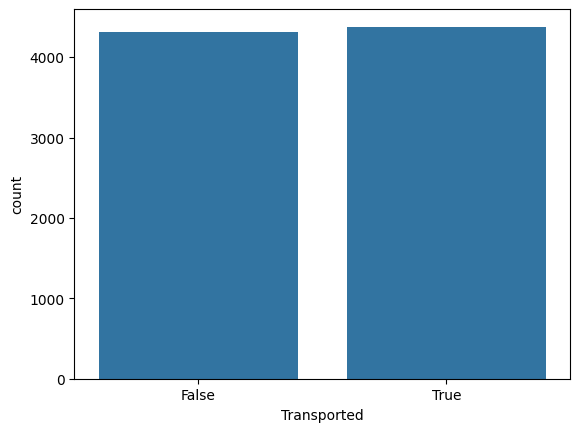

In [13]:
sns.countplot(data=df, x="Transported");

# Observations:
Missing Data and data Types

|Column Name| Missing Value %| dtype|
|:-------|:-------|:-------|
|PassengerId   |  0.000000 | object |
|HomePlanet    |  2.312205 | object|
|CryoSleep     |  0.000000 | object|
|Cabin         |  2.289198 | object|
|Destination   |  2.093639 | object|
|Age           |  2.059128 | Float|
|VIP           |  0.000000 | object|
|RoomService   |  2.082135 | Float|
|FoodCourt     |  2.105142 | Float|
|ShoppingMall  |  2.392730 | Float|
|Spa           |  2.105142 | Float|
|VRDeck        |  2.162660 | Float|
|Name          |  2.300702 | object|
|Transported   |  0.000000 | bool|


# Exploratory Data Analysis

## Target distribution

Text(0.5, 1.0, 'Transported Distribution')

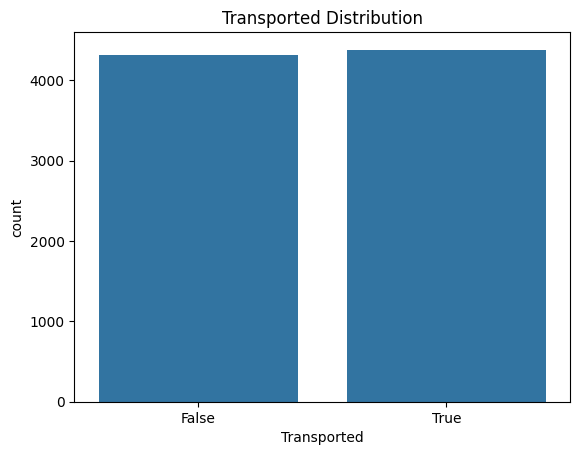

In [14]:
sns.countplot(x='Transported', data=df)
plt.title("Transported Distribution")

## Starting with Bi Variate against target

In [15]:
pd.crosstab(df['CryoSleep'], df['Transported'], normalize='index')


Transported,False,True
CryoSleep,,
False,0.671079,0.328921
True,0.204364,0.795636


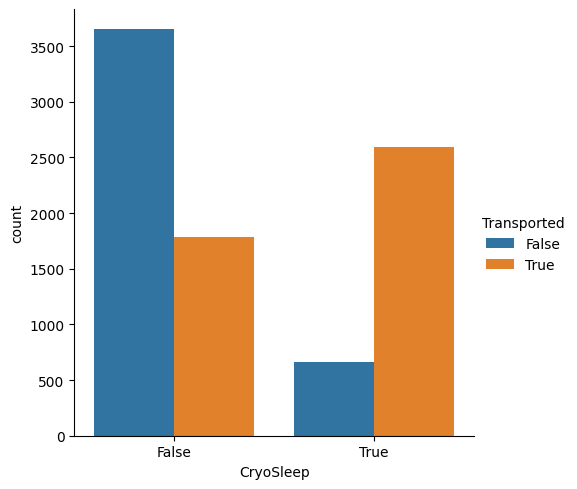

In [16]:
sns.catplot(x='CryoSleep', hue='Transported', kind='count', data=df)

### Observation: Cyrosleep increases chances of being transported

-------------------------------------------------------------------------

## Lets Merge all spendings

In [17]:
spend_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
df['TotalSpending'] = df[spend_cols].sum(axis=1)

<Axes: xlabel='Transported', ylabel='TotalSpending'>

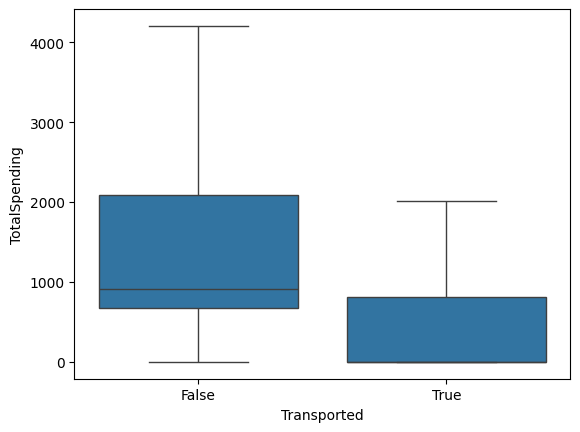

In [18]:
sns.boxplot(x='Transported', y='TotalSpending', data=df, showfliers=False)  # zoom in


## Observation : Most transported are having spending 0, correlate with cryosleep

<Axes: xlabel='TotalSpending', ylabel='Count'>

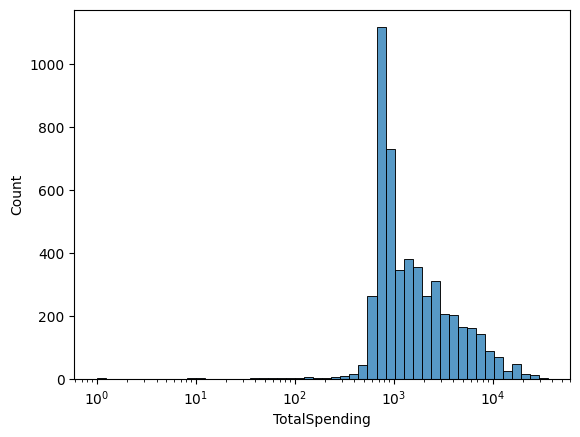

In [19]:
sns.histplot(df['TotalSpending'], bins=50, log_scale=True)  # many zeros

<Axes: xlabel='Transported', ylabel='Age'>

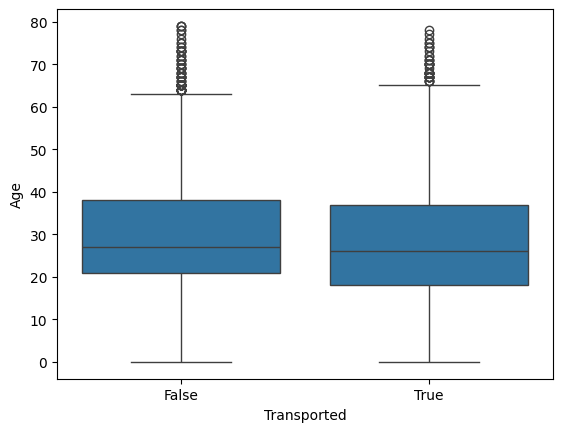

In [20]:
sns.boxplot(x='Transported', y='Age', data=df)

<Axes: xlabel='Age', ylabel='Count'>

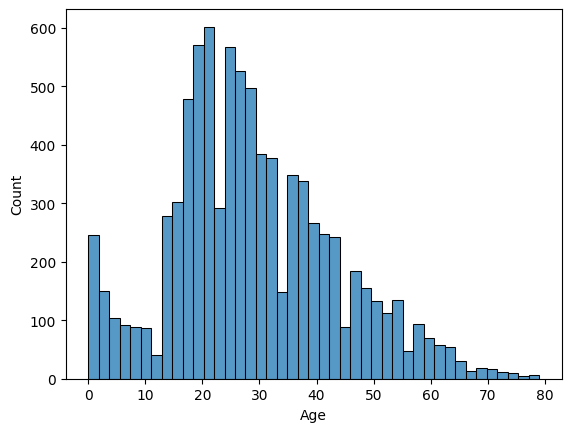

In [21]:
sns.histplot(data=df, x='Age')

<Axes: xlabel='Age', ylabel='Density'>

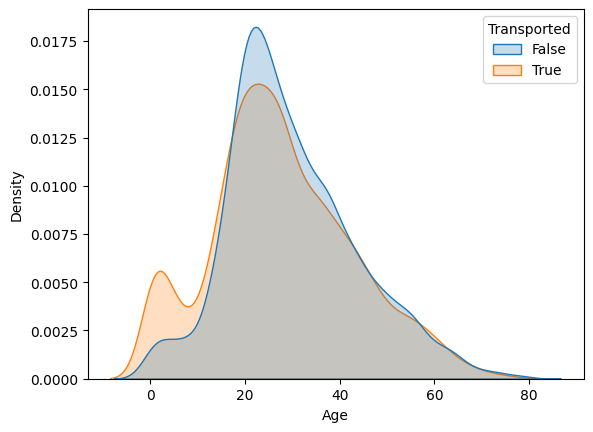

In [22]:
sns.kdeplot(data=df, x='Age', hue='Transported', fill=True)

## Observation : seems transported and transported have similar distribution, but there is a spike where most kids and youngsters are transported


________________________________________________________________________________________________________________________

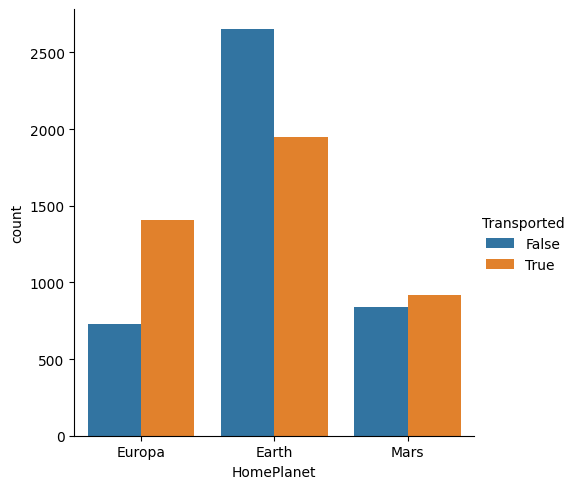

In [23]:
sns.catplot(x='HomePlanet', hue='Transported', kind='count', data=df)

In [24]:
pd.crosstab(df['HomePlanet'], df['Transported'], normalize='index')

Transported,False,True
HomePlanet,,
Earth,0.576054,0.423946
Europa,0.341154,0.658846
Mars,0.476976,0.523024


## Observation : people from Europa have been transported more

In [25]:
df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')

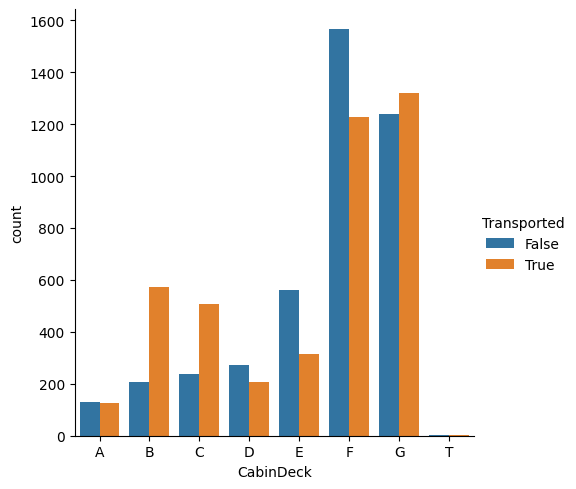

In [26]:
sns.catplot(x='CabinDeck', hue='Transported', kind='count', data=df, order=sorted(df['CabinDeck'].dropna().unique()))

## Observation : seems B and C have higher tranported chances

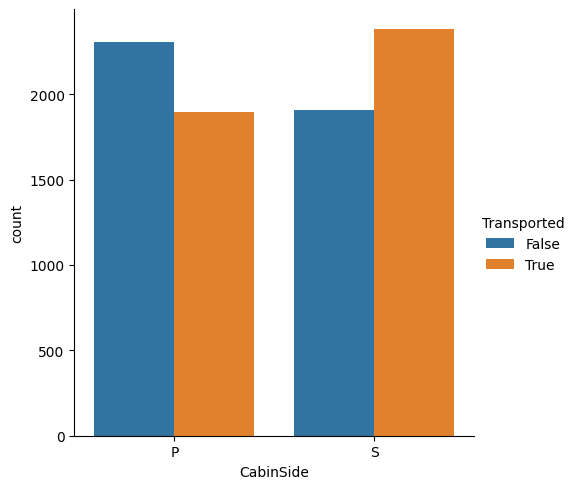

In [27]:
sns.catplot(x='CabinSide', hue='Transported', kind='count', data=df)

## Observation: S side have higher chances of being transported

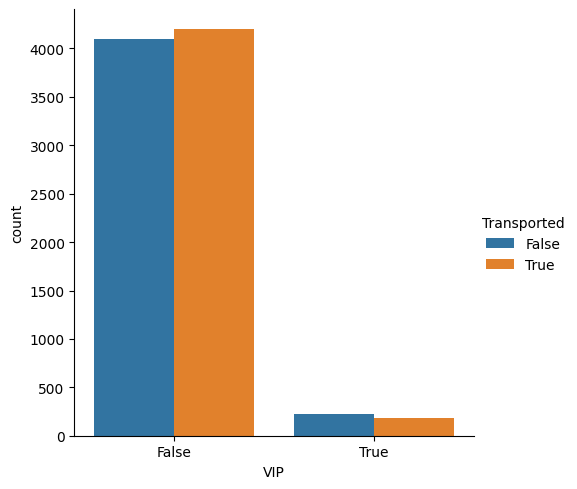

In [28]:
sns.catplot(x='VIP', hue='Transported', kind='count', data=df)

## Observation: seems the most transported are not VIPs and may be 50 % of VIPs are transported

In [29]:
df[['Group','PassengerNum']] = df['PassengerId'].str.split('_', expand=True)

df['Group'] = pd.to_numeric(df['Group'], errors='coerce')
df['PassengerNum'] = pd.to_numeric(df['PassengerNum'], errors='coerce')

In [30]:
group_sizes = df['Group'].value_counts().reset_index()
group_sizes.columns = ['Group', 'GroupSize']

In [31]:
df = df.merge(group_sizes, on='Group', how='left')

In [32]:
print(df[['PassengerId', 'Group', 'PassengerNum', 'GroupSize', 'Transported']].head(10))
print("\nGroupSize distribution:")
print(df['GroupSize'].value_counts().sort_index())

  PassengerId  Group  PassengerNum  GroupSize  Transported
0     0001_01      1             1          1        False
1     0002_01      2             1          1         True
2     0003_01      3             1          2        False
3     0003_02      3             2          2        False
4     0004_01      4             1          1         True
5     0005_01      5             1          1         True
6     0006_01      6             1          2         True
7     0006_02      6             2          2         True
8     0007_01      7             1          1         True
9     0008_01      8             1          3         True

GroupSize distribution:
GroupSize
1    4805
2    1682
3    1020
4     412
5     265
6     174
7     231
8     104
Name: count, dtype: int64


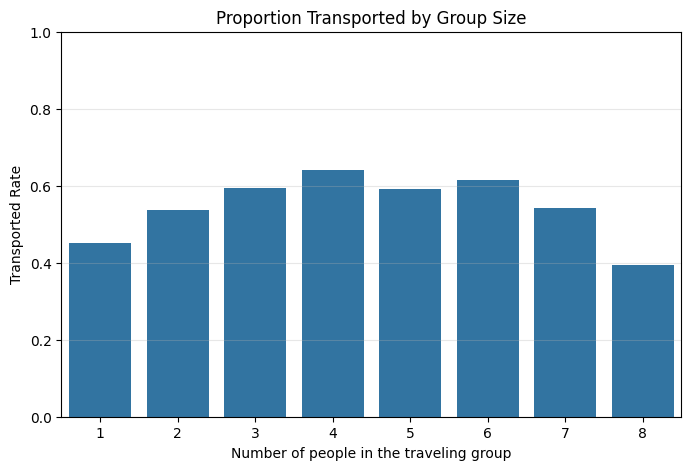

   GroupSize  Transported
0          1     0.452445
1          2     0.538050
2          3     0.593137
3          4     0.640777
4          5     0.592453
5          6     0.614943
6          7     0.541126
7          8     0.394231


In [33]:
# Bar plot with proportions
transported_by_size = df.groupby('GroupSize')['Transported'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='GroupSize', y='Transported', data=transported_by_size)
plt.title("Proportion Transported by Group Size")
plt.ylabel("Transported Rate")
plt.xlabel("Number of people in the traveling group")
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Also print numbers
print(transported_by_size)

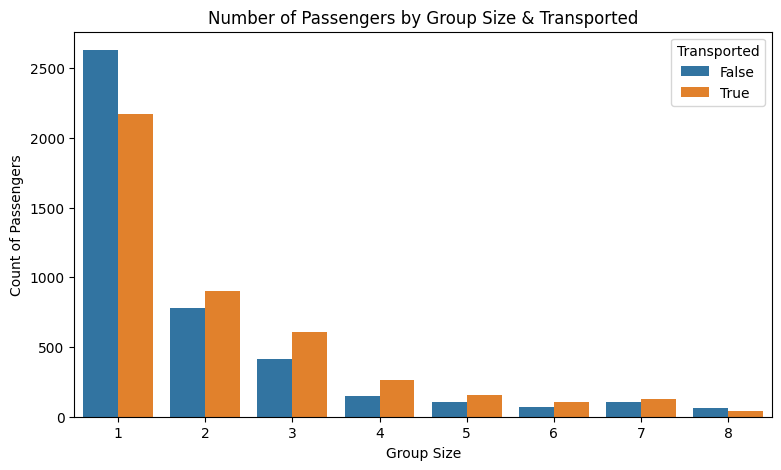

In [34]:
plt.figure(figsize=(9,5))
sns.countplot(x='GroupSize', hue='Transported', data=df)
plt.title("Number of Passengers by Group Size & Transported")
plt.xlabel("Group Size")
plt.ylabel("Count of Passengers")
plt.show()

Transported     False     True 
IsSolo                         
False        0.433128  0.566872
True         0.547555  0.452445


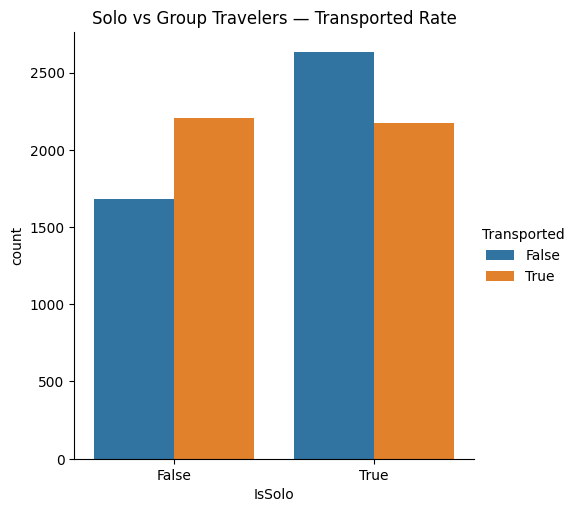

In [35]:
df['IsSolo'] = df['GroupSize'] == 1

# Quick crosstab
print(pd.crosstab(df['IsSolo'], df['Transported'], normalize='index'))

# Plot
sns.catplot(x='IsSolo', hue='Transported', kind='count', data=df)
plt.title("Solo vs Group Travelers — Transported Rate")
plt.show()

## Observation
Passengers traveling in small-to-medium groups (especially size 3–6) are noticeably more likely to be transported (nearly 59–64%) compared to solo travelers (nearly 45%).
Very large groups (8+) and solo travelers appear less affected — possibly because they are assigned to different cabin sections or behaved differently during the anomaly.


GroupSize is a useful predictor. We should include it (or IsSolo + maybe dummies for size 3–6) in our model.

________________________________________________________________________________________

## Imputation
- 0 spending -> cryosleep is True
- Age with median
- home planet and destination with mode
- if missing VIP will be false since its very minimal 
- cabin filling with Unkown/0/U to keep it uniform with other cabin ids


In [36]:
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df[spend_cols] = df[spend_cols].fillna(0)

df['TotalSpending'] = df[spend_cols].sum(axis=1)

df['NoSpending'] = (df['TotalSpending'] == 0).astype(int)

In [37]:

#pd.set_option('future.no_silent_downcasting', True)

In [38]:
df['CryoSleep'] = df['CryoSleep'].astype('object')  # to allow filling
df.loc[(df['TotalSpending'] > 0) & (df['CryoSleep'].isna()), 'CryoSleep'] = False
df.fillna({'CryoSleep': False}, inplace=True)
df['CryoSleep'] = df['CryoSleep'].astype(bool)

In [39]:
df.fillna({'Age':df['Age'].median()}, inplace=True)

In [40]:
df.fillna({'HomePlanet':df['HomePlanet'].mode()[0]}, inplace=True)
df.fillna({'Destination':df['Destination'].mode()[0]}, inplace=True)

In [41]:
df.fillna({'VIP':False}, inplace=True)

In [42]:
df.fillna({'Cabin':'Unknown/0/U'}, inplace=True)

In [43]:
print(df.isna().sum())

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             200
Transported        0
TotalSpending      0
CabinDeck        199
CabinNum         199
CabinSide        199
Group              0
PassengerNum       0
GroupSize          0
IsSolo             0
NoSpending         0
dtype: int64


In [44]:
df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
df.fillna({'CabinNum':-1}, inplace=True)  # -1 for unknown

In [45]:
deck_order = ['A','B','C','D','E','F','G','T','Unknown']
df['CabinDeck'] = pd.Categorical(df['CabinDeck'], categories=deck_order, ordered=True)

In [46]:
df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=[0, 5, 12, 18, 25, 35, 50, 100],
                        labels=['0-5', '6-12', '13-18', '19-25', '26-35', '36-50', '50+'],
                        right=False)

In [47]:
df['IsChild'] = (df['Age'] < 13).astype(int)     # under ~13 often higher transported
df['IsYoungAdult'] = ((df['Age'] >= 18) & (df['Age'] <= 30)).astype(int)

In [48]:
df['FromEuropa'] = (df['HomePlanet'] == 'Europa').astype(int)

In [49]:
df['CabinSide'] = df['CabinSide'].map({'P': 0, 'S': 1, 'U': -1})  # numeric for model

In [50]:

print("NoSpending vs Transported:")
print(pd.crosstab(df['NoSpending'], df['Transported'], normalize='index'))

print("\nFromEuropa vs Transported:")
print(pd.crosstab(df['FromEuropa'], df['Transported'], normalize='index'))

print("\nIsChild vs Transported:")
print(pd.crosstab(df['IsChild'], df['Transported'], normalize='index'))

# Save cleaned + featured data (very important!)
df.to_csv('spaceship_cleaned_featured.csv', index=False)


NoSpending vs Transported:
Transported     False     True 
NoSpending                     
0            0.701389  0.298611
1            0.213523  0.786477

FromEuropa vs Transported:
Transported     False     True 
FromEuropa                     
0            0.546785  0.453215
1            0.341154  0.658846

IsChild vs Transported:
Transported     False     True 
IsChild                        
0            0.516419  0.483581
1            0.300248  0.699752


In [51]:
df.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             200
Transported        0
TotalSpending      0
CabinDeck          0
CabinNum           0
CabinSide          0
Group              0
PassengerNum       0
GroupSize          0
IsSolo             0
NoSpending         0
AgeGroup           0
IsChild            0
IsYoungAdult       0
FromEuropa         0
dtype: int64

In [52]:
df.drop(columns=['Name'], inplace=True)

In [53]:
print(df.isna().sum())

PassengerId      0
HomePlanet       0
CryoSleep        0
Cabin            0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Transported      0
TotalSpending    0
CabinDeck        0
CabinNum         0
CabinSide        0
Group            0
PassengerNum     0
GroupSize        0
IsSolo           0
NoSpending       0
AgeGroup         0
IsChild          0
IsYoungAdult     0
FromEuropa       0
dtype: int64


In [54]:
# redoing to ensure
df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)


df['CabinDeck'].fillna('Unknown', inplace=True)
df['CabinSide'].fillna('U', inplace=True)   # U for unknown
df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce').fillna(-1)


df.drop(columns=['Cabin'], inplace=True)


cat_cols_to_encode = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']

df_encoded = pd.get_dummies(df, columns=cat_cols_to_encode, drop_first=True, dtype=int)

print(df_encoded.shape)   
print(df_encoded.head(3))

(8693, 35)
  PassengerId  CryoSleep   Age    VIP  RoomService  FoodCourt  ShoppingMall  \
0     0001_01      False  39.0  False          0.0        0.0           0.0   
1     0002_01      False  24.0  False        109.0        9.0          25.0   
2     0003_01      False  58.0   True         43.0     3576.0           0.0   

      Spa  VRDeck  Transported  ...  CabinDeck_B  CabinDeck_C  CabinDeck_D  \
0     0.0     0.0        False  ...            1            0            0   
1   549.0    44.0         True  ...            0            0            0   
2  6715.0    49.0        False  ...            0            0            0   

   CabinDeck_E  CabinDeck_F  CabinDeck_G  CabinDeck_T CabinDeck_Unknown  \
0            0            0            0            0                 0   
1            0            1            0            0                 0   
2            0            0            0            0                 0   

   CabinSide_S  CabinSide_U  
0            0            0 

## Training Data and testing data

In [55]:
df = pd.read_csv("data/train.csv")
def preprocessing(df):
    df[['Group','PassengerNum']] = df['PassengerId'].str.split('_', expand=True)
    df['Group'] = pd.to_numeric(df['Group'], errors='coerce')
    df['PassengerNum'] = pd.to_numeric(df['PassengerNum'], errors='coerce')
    group_sizes = df['Group'].value_counts().reset_index()
    group_sizes.columns = ['Group', 'GroupSize']
    df = df.merge(group_sizes, on='Group', how='left')
    df['IsSolo'] = df['GroupSize'] == 1
    spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df[spend_cols] = df[spend_cols].fillna(0)
    df['TotalSpending'] = df[spend_cols].sum(axis=1)
    df['NoSpending'] = (df['TotalSpending'] == 0).astype(int)
    df['CryoSleep'] = df['CryoSleep'].astype('object')  # to allow filling
    df.loc[(df['TotalSpending'] > 0) & (df['CryoSleep'].isna()), 'CryoSleep'] = False
    df.fillna({'CryoSleep': False}, inplace=True)
    df['CryoSleep'] = df['CryoSleep'].astype(bool)
    df['CryoSleep'] = df['CryoSleep'].astype(int)
    df.fillna({'Age':df['Age'].median()}, inplace=True)
    df.fillna({'HomePlanet':df['HomePlanet'].mode()[0]}, inplace=True)
    df.fillna({'Destination':df['Destination'].mode()[0]}, inplace=True)
    df.fillna({'VIP':False}, inplace=True)
    df.fillna({'Cabin':'Unknown/0/U'}, inplace=True)
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
    df.fillna({'CabinNum':-1}, inplace=True)  # -1 for unknown
    deck_order = ['A','B','C','D','E','F','G','T','Unknown']
    df['CabinDeck'] = pd.Categorical(df['CabinDeck'], categories=deck_order, ordered=True)
    df['AgeGroup'] = pd.cut(df['Age'], 
                            bins=[0, 5, 12, 18, 25, 35, 50, 100],
                            labels=['0-5', '6-12', '13-18', '19-25', '26-35', '36-50', '50+'],
                            right=False)
    df['IsChild'] = (df['Age'] < 13).astype(int)     # under ~13 often higher transported
    df['IsYoungAdult'] = ((df['Age'] >= 18) & (df['Age'] <= 30)).astype(int)
    df['FromEuropa'] = (df['HomePlanet'] == 'Europa').astype(int)
    df['CabinSide'] = df['CabinSide'].map({'P': 0, 'S': 1, 'U': -1})  # numeric for model
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    
    
    df['CabinDeck'].fillna('Unknown', inplace=True)
    df['CabinSide'].fillna('U', inplace=True)   # U for unknown
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce').fillna(-1)
    cat_cols_to_encode = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']
    df_encoded = pd.get_dummies(df, columns=cat_cols_to_encode, drop_first=True, dtype=int)
    df_encoded.drop(columns=['Cabin','PassengerId', 'CabinNum', 'Group', 'PassengerNum', "AgeGroup","Name"], inplace=True)
    df_encoded['IsSolo']= df_encoded['IsSolo'].astype(int)
    df_encoded['VIP']= df_encoded['VIP'].astype(int)
    df_encoded['CryoSleep']= df_encoded['CryoSleep'].astype(int)
    return df_encoded


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import shap
import matplotlib.pyplot as plt

def get_best_model(df_encoded):
    # Target
    y = df_encoded['Transported'].astype(int)   # 0/1 for models
    
    X = df_encoded
    X.drop(columns=["Transported"], inplace=True)
    
    # Stratified split (important because ~50/50 but let's be safe)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.20,
        stratify=y,
        random_state=42
    )
    
    print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")
    print(f"Train Transported rate: {y_train.mean():.4f}")
    models = {
    'Dummy (most frequent)': DummyClassifier(strategy='most_frequent'),
    'LogisticRegression': LogisticRegression(max_iter=100000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
    }

    results = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:,1] if hasattr(model, 'predict_proba') else None
        
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba) if y_proba is not None else None
        
        results.append({
            'Model': name,
            'Accuracy': acc,
            'F1': f1,
            'ROC-AUC': auc
        })
    
    print(pd.DataFrame(results).round(4))

    ## Light hyperparameter tuning on XGBoost

    xgb = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
    
    param_dist = {
        'n_estimators':     [100, 200, 300, 400],
        'max_depth':        [3, 5, 7, 9],
        'learning_rate':    [0.01, 0.05, 0.1, 0.2],
        'subsample':        [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    }
    
    search = RandomizedSearchCV(
        xgb, param_distributions=param_dist,
        n_iter=15,           # only 15 random combinations – fast
        cv=5,                # 5-fold CV
        scoring='roc_auc',   # or 'f1' if you prefer
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    
    print("Best params:", search.best_params_)
    print("Best CV ROC-AUC:", search.best_score_.round(4))
    
    # Evaluate best model on validation set
    best_model = search.best_estimator_
    y_pred_val  = best_model.predict(X_val)
    y_proba_val = best_model.predict_proba(X_val)[:,1]
    
    print("Val Accuracy:", round(accuracy_score(y_val, y_pred_val),4))
    print("Val F1:      ", round(f1_score(y_val, y_pred_val),4))
    print("Val ROC-AUC: ", round(roc_auc_score(y_val, y_proba_val),4))
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_val)
    
    # Beeswarm plot (shows direction + importance)
    shap.summary_plot(shap_values, X_val, show=False)
    plt.title("SHAP Summary - What drives Transported prediction?")
    plt.tight_layout()
    plt.show()
    
    # faster bar plot
    shap.summary_plot(shap_values, X_val, plot_type="bar")
    importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("Top 10 features:")
    print(importances.head(10))
    
    importances.head(15).plot(kind='barh', figsize=(10,6))
    plt.title("XGBoost Feature Importance (Gain)")
    plt.show()
    val_df = X_val.copy()
    val_df['True'] = y_val
    val_df['Pred'] = best_model.predict(X_val)
    val_df['Proba'] = best_model.predict_proba(X_val)[:,1]
    val_df['Error'] = val_df['True'] != val_df['Pred']
    
    # Error rate by key groups
    print("Overall error rate:", val_df['Error'].mean().round(4))
    print("\nError when CryoSleep == 1:", val_df[val_df['CryoSleep'] == 1]['Error'].mean().round(4))
    print("Error when CryoSleep == 0:", val_df[val_df['CryoSleep'] == 0]['Error'].mean().round(4))
    print("\nError when NoSpending == 1:", val_df[val_df['NoSpending'] == 1]['Error'].mean().round(4))
    print("Error when FromEuropa == 1:", val_df[val_df['FromEuropa'] == 1]['Error'].mean().round(4))
    print("Error when IsChild == 1:", val_df[val_df['IsChild'] == 1]['Error'].mean().round(4))
    return best_model

Train shape: (6954, 29), Val shape: (1739, 29)
Train Transported rate: 0.5036
                   Model  Accuracy      F1  ROC-AUC
0  Dummy (most frequent)    0.5037  0.6700   0.5000
1     LogisticRegression    0.7913  0.7941   0.8828
2           RandomForest    0.7918  0.7866   0.8774
3                XGBoost    0.8102  0.8116   0.8947
Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\vinay\.conda\envs\torch311\Lib\site-packages\xgboost\training.py:199: UserWarning: [03:50:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best CV ROC-AUC: 0.8881
Val Accuracy: 0.8056
Val F1:       0.812
Val ROC-AUC:  0.8974


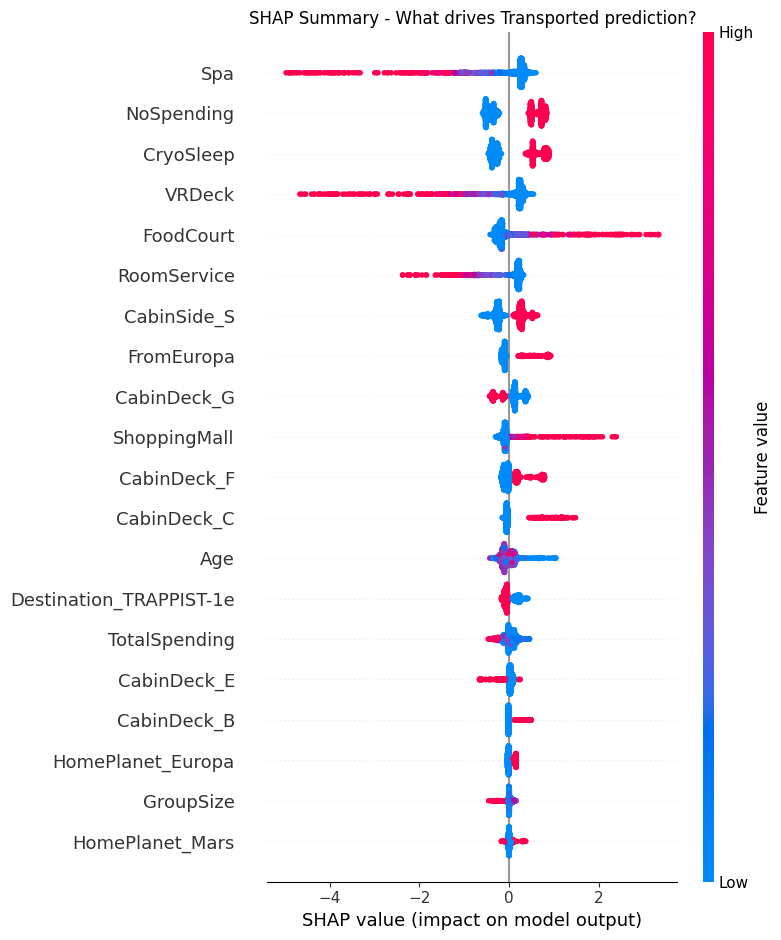

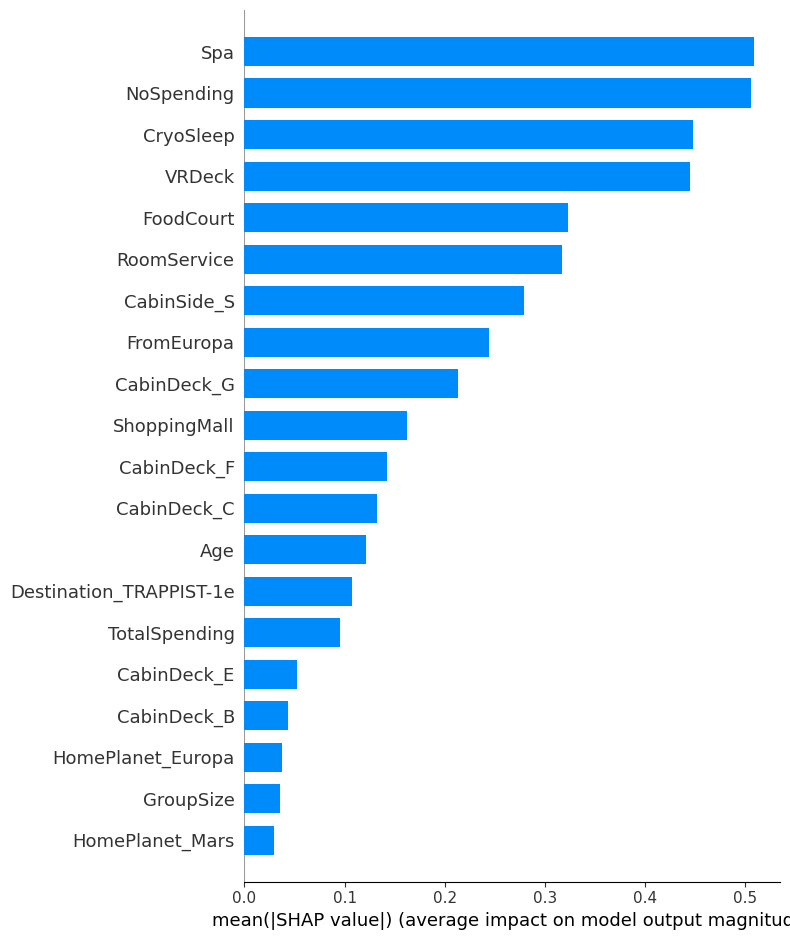

Top 10 features:
NoSpending           0.458391
CryoSleep            0.120189
CabinDeck_G          0.057312
FromEuropa           0.043351
HomePlanet_Europa    0.036559
CabinDeck_E          0.021886
RoomService          0.021716
Spa                  0.020789
CabinDeck_F          0.020203
FoodCourt            0.019350
dtype: float32


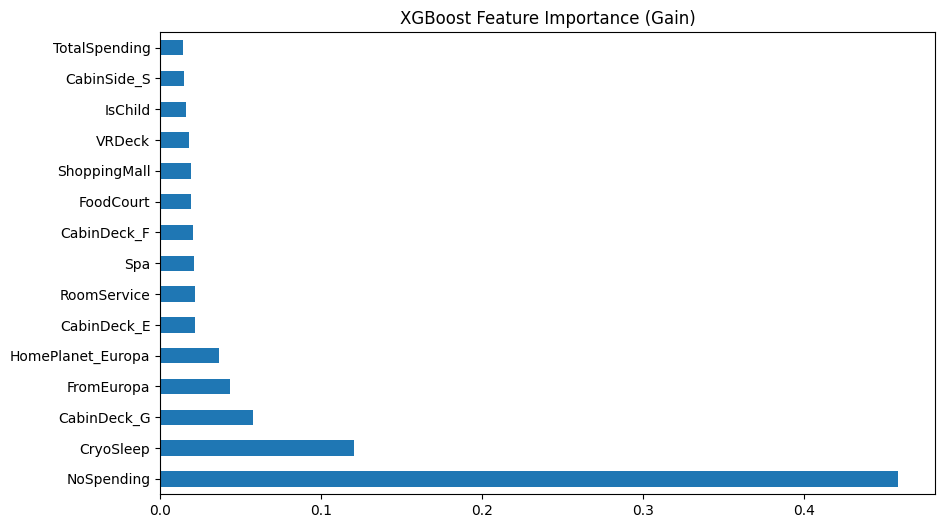

Overall error rate: 0.1944

Error when CryoSleep == 1: 0.178
Error when CryoSleep == 0: 0.203

Error when NoSpending == 1: 0.2054
Error when FromEuropa == 1: 0.0774
Error when IsChild == 1: 0.2695


In [69]:
df_encoded = preprocessing(df)
best_model = get_best_model(df_encoded)

In [70]:
# Load test set (make sure you have test.csv in same folder)
df_test = pd.read_csv("data/test.csv")   # adjust path
df_test_encoded = preprocessing(df_test)




In [71]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   int32  
 1   Age                        4277 non-null   float64
 2   VIP                        4277 non-null   int32  
 3   RoomService                4277 non-null   float64
 4   FoodCourt                  4277 non-null   float64
 5   ShoppingMall               4277 non-null   float64
 6   Spa                        4277 non-null   float64
 7   VRDeck                     4277 non-null   float64
 8   GroupSize                  4277 non-null   int64  
 9   IsSolo                     4277 non-null   int32  
 10  TotalSpending              4277 non-null   float64
 11  NoSpending                 4277 non-null   int32  
 12  IsChild                    4277 non-null   int32  
 13  IsYoungAdult               4277 non-null   int32

In [73]:
# Predict
test_proba = best_model.predict_proba(df_test_encoded)[:,1]
df_test['Transported'] = test_proba > 0.4   # or use best threshold if you tuned one

# Submission format
submission = df_test[['PassengerId', 'Transported']]
submission.to_csv("submission_xgb_tuned.csv", index=False)
print("Submission file created!")

Submission file created!


## Iteration 2

In [76]:
df = pd.read_csv("data/train.csv")
def preprocessing2(df):
    df[['Group','PassengerNum']] = df['PassengerId'].str.split('_', expand=True)
    df['Group'] = pd.to_numeric(df['Group'], errors='coerce')
    df['PassengerNum'] = pd.to_numeric(df['PassengerNum'], errors='coerce')
    group_sizes = df['Group'].value_counts().reset_index()
    group_sizes.columns = ['Group', 'GroupSize']
    df = df.merge(group_sizes, on='Group', how='left')
    df['IsSolo'] = df['GroupSize'] == 1
    spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df[spend_cols] = df[spend_cols].fillna(0)
    df['TotalSpending'] = df[spend_cols].sum(axis=1)
    df['NoSpending'] = (df['TotalSpending'] == 0).astype(int)
    df['CryoSleep'] = df['CryoSleep'].astype('object')  # to allow filling
    df.loc[(df['TotalSpending'] > 0) & (df['CryoSleep'].isna()), 'CryoSleep'] = False
    df.fillna({'CryoSleep': False}, inplace=True)
    df['CryoSleep'] = df['CryoSleep'].astype(bool)
    df['CryoSleep'] = df['CryoSleep'].astype(int)
    df.fillna({'Age':df['Age'].median()}, inplace=True)
    df.fillna({'HomePlanet':df['HomePlanet'].mode()[0]}, inplace=True)
    df.fillna({'Destination':df['Destination'].mode()[0]}, inplace=True)
    df.fillna({'VIP':False}, inplace=True)
    df.fillna({'Cabin':'Unknown/0/U'}, inplace=True)
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
    df.fillna({'CabinNum':-1}, inplace=True)  # -1 for unknown
    deck_order = ['A','B','C','D','E','F','G','T','Unknown']
    df['CabinDeck'] = pd.Categorical(df['CabinDeck'], categories=deck_order, ordered=True)
    df['AgeGroup'] = pd.cut(df['Age'], 
                            bins=[0, 5, 12, 18, 25, 35, 50, 100],
                            labels=['0-5', '6-12', '13-18', '19-25', '26-35', '36-50', '50+'],
                            right=False)
    df['IsChild'] = (df['Age'] < 13).astype(int)     # under ~13 often higher transported
    df['IsYoungAdult'] = ((df['Age'] >= 18) & (df['Age'] <= 30)).astype(int)
    df['FromEuropa'] = (df['HomePlanet'] == 'Europa').astype(int)
    df['CabinSide'] = df['CabinSide'].map({'P': 0, 'S': 1, 'U': -1})  # numeric for model
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    
    
    df['CabinDeck'].fillna('Unknown', inplace=True)
    df['CabinSide'].fillna('U', inplace=True)   # U for unknown
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce').fillna(-1)
    cat_cols_to_encode = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']
    df_encoded = pd.get_dummies(df, columns=cat_cols_to_encode, drop_first=True, dtype=int)
    df_encoded.drop(columns=['Cabin','PassengerId', 'CabinNum', 'Group', 'PassengerNum', "AgeGroup","Name"], inplace=True)
    df_encoded['IsSolo']= df_encoded['IsSolo'].astype(int)
    df_encoded['VIP']= df_encoded['VIP'].astype(int)
    df_encoded['CryoSleep']= df_encoded['CryoSleep'].astype(int)
    df_encoded['AwakeNoSpending'] = ((df_encoded['CryoSleep'] == 0) & (df_encoded['NoSpending'] == 1)).astype(int)
    df_encoded['ChildInGroup'] = ((df_encoded['IsChild'] == 1) & (df_encoded['IsSolo'] == 0)).astype(int)
    return df_encoded


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def get_best_model2(df_encoded):
    # Target
    y = df_encoded['Transported'].astype(int)   # 0/1 for models
    
    X = df_encoded
    X.drop(columns=["Transported"], inplace=True)
    
    # Stratified split (important because ~50/50 but let's be safe)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.20,
        stratify=y,
        random_state=42
    )
    
    print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")
    print(f"Train Transported rate: {y_train.mean():.4f}")
    models = {
    'Dummy (most frequent)': DummyClassifier(strategy='most_frequent'),
    'LogisticRegression': LogisticRegression(max_iter=100000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
    }

    results = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:,1] if hasattr(model, 'predict_proba') else None
        
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba) if y_proba is not None else None
        
        results.append({
            'Model': name,
            'Accuracy': acc,
            'F1': f1,
            'ROC-AUC': auc
        })
    
    print(pd.DataFrame(results).round(4))

    ## Light hyperparameter tuning on XGBoost

    xgb = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
    
    param_dist = {
        'n_estimators':     [100, 200, 300, 400],
        'max_depth':        [3, 5, 7, 9],
        'learning_rate':    [0.01, 0.05, 0.1, 0.2],
        'subsample':        [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    }
    
    search = RandomizedSearchCV(
        xgb, param_distributions=param_dist,
        n_iter=15,           # only 15 random combinations – fast
        cv=5,                # 5-fold CV
        scoring='roc_auc',   # or 'f1' if you prefer
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    
    print("Best params:", search.best_params_)
    print("Best CV ROC-AUC:", search.best_score_.round(4))
    
    # Evaluate best model on validation set
    best_model = search.best_estimator_
    y_pred_val  = best_model.predict(X_val)
    y_proba_val = best_model.predict_proba(X_val)[:,1]
    
    print("Val Accuracy:", round(accuracy_score(y_val, y_pred_val),4))
    print("Val F1:      ", round(f1_score(y_val, y_pred_val),4))
    print("Val ROC-AUC: ", round(roc_auc_score(y_val, y_proba_val),4))
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_val)
    
    # Beeswarm plot (shows direction + importance)
    shap.summary_plot(shap_values, X_val, show=False)
    plt.title("SHAP Summary - What drives Transported prediction?")
    plt.tight_layout()
    plt.show()
    
    # faster bar plot
    shap.summary_plot(shap_values, X_val, plot_type="bar")
    importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("Top 10 features:")
    print(importances.head(10))
    
    importances.head(15).plot(kind='barh', figsize=(10,6))
    plt.title("XGBoost Feature Importance (Gain)")
    plt.show()
    
    val_df = X_val.copy()
    val_df['True'] = y_val
    val_df['Pred'] = best_model.predict(X_val)
    val_df['Proba'] = best_model.predict_proba(X_val)[:,1]
    val_df['Error'] = val_df['True'] != val_df['Pred']
    
    # Error rate by key groups
    print("Overall error rate:", val_df['Error'].mean().round(4))
    print("\nError when CryoSleep == 1:", val_df[val_df['CryoSleep'] == 1]['Error'].mean().round(4))
    print("Error when CryoSleep == 0:", val_df[val_df['CryoSleep'] == 0]['Error'].mean().round(4))
    print("\nError when NoSpending == 1:", val_df[val_df['NoSpending'] == 1]['Error'].mean().round(4))
    print("Error when FromEuropa == 1:", val_df[val_df['FromEuropa'] == 1]['Error'].mean().round(4))
    print("Error when IsChild == 1:", val_df[val_df['IsChild'] == 1]['Error'].mean().round(4))
    print("Error when AwakeNoSpending == 1:", val_df[val_df['AwakeNoSpending'] == 1]['Error'].mean().round(4))
    print("Error when ChildInGroup == 1:", val_df[val_df['ChildInGroup'] == 1]['Error'].mean().round(4))
    
    probas = best_model.predict_proba(X_val)[:,1]
    thresholds = np.arange(0.3, 0.7, 0.02)
    f1_scores = [f1_score(y_val, probas > t) for t in thresholds]
    
    best_t = thresholds[np.argmax(f1_scores)]
    print(f"Best threshold: {best_t:.2f} → F1: {max(f1_scores):.4f}")
    return best_model

Train shape: (6954, 31), Val shape: (1739, 31)
Train Transported rate: 0.5036
                   Model  Accuracy      F1  ROC-AUC
0  Dummy (most frequent)    0.5037  0.6700   0.5000
1     LogisticRegression    0.7901  0.7934   0.8817
2           RandomForest    0.7890  0.7827   0.8727
3                XGBoost    0.8154  0.8196   0.8943
Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\vinay\.conda\envs\torch311\Lib\site-packages\xgboost\training.py:199: UserWarning: [03:59:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best CV ROC-AUC: 0.8881
Val Accuracy: 0.8097
Val F1:       0.8162
Val ROC-AUC:  0.8975


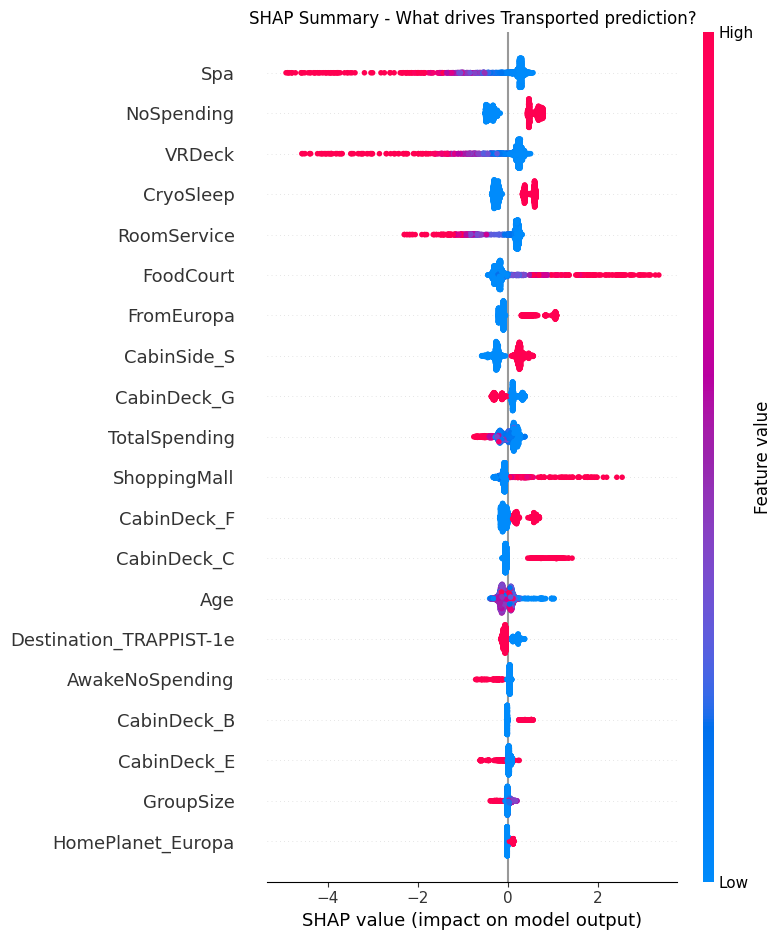

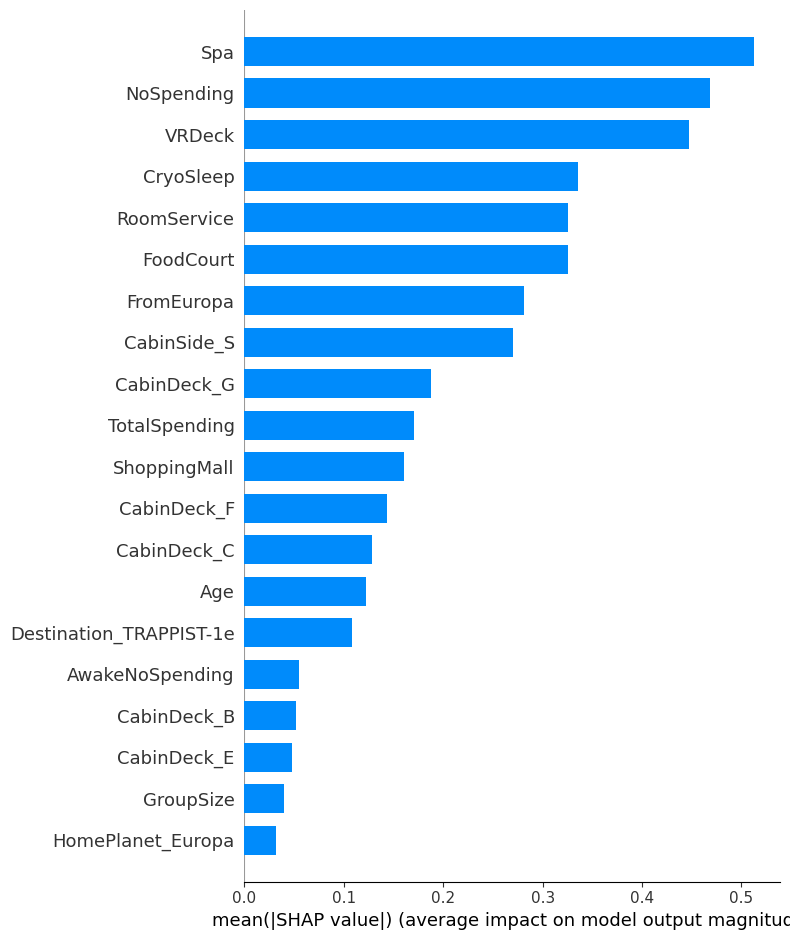

Top 10 features:
NoSpending           0.465478
CryoSleep            0.108894
CabinDeck_G          0.049336
FromEuropa           0.045826
TotalSpending        0.031232
HomePlanet_Europa    0.029590
CabinDeck_E          0.023529
CabinDeck_F          0.021427
Spa                  0.021306
FoodCourt            0.019999
dtype: float32


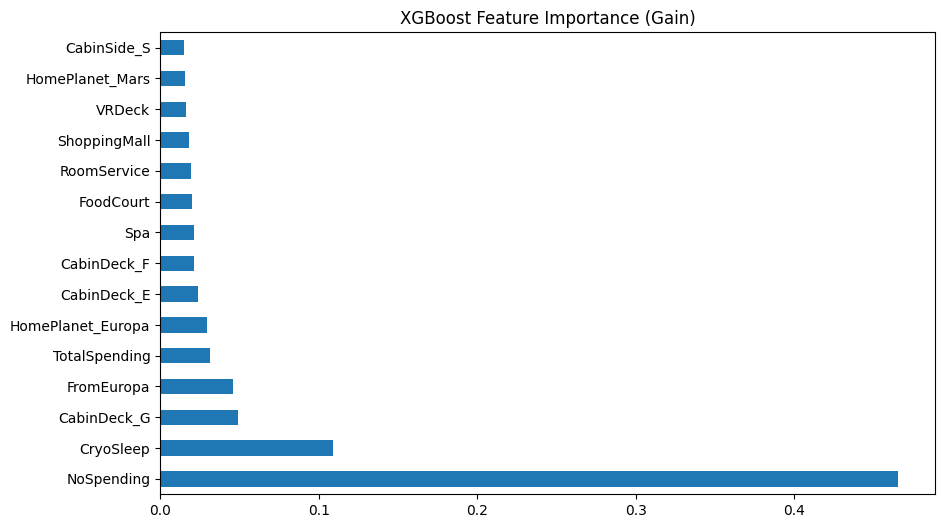

Overall error rate: 0.1903

Error when CryoSleep == 1: 0.183
Error when CryoSleep == 0: 0.1942

Error when NoSpending == 1: 0.2082
Error when FromEuropa == 1: 0.0706
Error when IsChild == 1: 0.2837
Error when AwakeNoSpending == 1: 0.3524
Error when ChildInGroup == 1: 0.2636
Best threshold: 0.40 → F1: 0.8201


In [85]:
df_encoded = preprocessing2(df)
best_model = get_best_model2(df_encoded)

In [86]:
df_test = pd.read_csv("data/test.csv")
df_test_encoded = preprocessing2(df_test)

In [88]:
# Predict
test_proba = best_model.predict_proba(df_test_encoded)[:,1]
df_test['Transported'] = test_proba >= 0.4   # or use best threshold if you tuned one

# Submission format
submission = df_test[['PassengerId', 'Transported']]
submission.to_csv("submission_xgb_tuned.csv", index=False)
print("Submission file created!")

Submission file created!


# Iteration 3

In [93]:
df = pd.read_csv("data/train.csv")
def preprocessing3(df):
    df[['Group','PassengerNum']] = df['PassengerId'].str.split('_', expand=True)
    df['Group'] = pd.to_numeric(df['Group'], errors='coerce')
    df['PassengerNum'] = pd.to_numeric(df['PassengerNum'], errors='coerce')
    group_sizes = df['Group'].value_counts().reset_index()
    group_sizes.columns = ['Group', 'GroupSize']
    df = df.merge(group_sizes, on='Group', how='left')
    df['IsSolo'] = df['GroupSize'] == 1
    spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df[spend_cols] = df[spend_cols].fillna(0)
    df['TotalSpending'] = df[spend_cols].sum(axis=1)
    df['NoSpending'] = (df['TotalSpending'] == 0).astype(int)
    df['CryoSleep'] = df['CryoSleep'].astype('object')  # to allow filling
    df.loc[(df['TotalSpending'] > 0) & (df['CryoSleep'].isna()), 'CryoSleep'] = False
    df.fillna({'CryoSleep': False}, inplace=True)
    df['CryoSleep'] = df['CryoSleep'].astype(bool)
    df['CryoSleep'] = df['CryoSleep'].astype(int)
    df.fillna({'Age':df['Age'].median()}, inplace=True)
    df.fillna({'HomePlanet':df['HomePlanet'].mode()[0]}, inplace=True)
    df.fillna({'Destination':df['Destination'].mode()[0]}, inplace=True)
    df.fillna({'VIP':False}, inplace=True)
    df.fillna({'Cabin':'Unknown/0/U'}, inplace=True)
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
    df.fillna({'CabinNum':-1}, inplace=True)  # -1 for unknown
    deck_order = ['A','B','C','D','E','F','G','T','Unknown']
    df['CabinDeck'] = pd.Categorical(df['CabinDeck'], categories=deck_order, ordered=True)
    df['AgeGroup'] = pd.cut(df['Age'], 
                            bins=[0, 5, 12, 18, 25, 35, 50, 100],
                            labels=['0-5', '6-12', '13-18', '19-25', '26-35', '36-50', '50+'],
                            right=False)
    df['IsChild'] = (df['Age'] < 13).astype(int)     # under ~13 often higher transported
    df['IsYoungAdult'] = ((df['Age'] >= 18) & (df['Age'] <= 30)).astype(int)
    df['FromEuropa'] = (df['HomePlanet'] == 'Europa').astype(int)
    df['CabinSide'] = df['CabinSide'].map({'P': 0, 'S': 1, 'U': -1})  # numeric for model
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    
    
    df['CabinDeck'].fillna('Unknown', inplace=True)
    df['CabinSide'].fillna('U', inplace=True)   # U for unknown
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce').fillna(-1)
    cat_cols_to_encode = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']
    df_encoded = pd.get_dummies(df, columns=cat_cols_to_encode, drop_first=True, dtype=int)
    df_encoded.drop(columns=['Cabin','PassengerId', 'CabinNum', 'Group', 'PassengerNum', "AgeGroup","Name"], inplace=True)
    df_encoded['IsSolo']= df_encoded['IsSolo'].astype(int)
    df_encoded['VIP']= df_encoded['VIP'].astype(int)
    df_encoded['CryoSleep']= df_encoded['CryoSleep'].astype(int)
    df_encoded['AwakeNoSpending'] = ((df_encoded['CryoSleep'] == 0) & (df_encoded['NoSpending'] == 1)).astype(int)
    df_encoded['ChildInGroup'] = ((df_encoded['IsChild'] == 1) & (df_encoded['IsSolo'] == 0)).astype(int)
    df_encoded['AwakeNoSpending_CabinG'] = ((df_encoded['AwakeNoSpending'] == 1) & (df_encoded['CabinDeck_G'] == 1)).astype(int)
    df_encoded['ChildCryo'] = ((df_encoded['IsChild'] == 1) & (df_encoded['CryoSleep'] == 1)).astype(int)
    # 1. AwakeNoSpending in Deck G (the 37.7% error group)
    df_encoded['AwakeNoSpending_DeckG'] = ((df_encoded['AwakeNoSpending'] == 1) & (df_encoded['CabinDeck_G'] == 1)).astype(int)
    
    # 2. Awake + Child (maybe awake kids are different)
    df_encoded['AwakeChild'] = ((df_encoded['CryoSleep'] == 0) & (df_encoded['IsChild'] == 1)).astype(int)
    return df_encoded


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def get_best_model3(df_encoded):
    # Target
    y = df_encoded['Transported'].astype(int)   # 0/1 for models
    
    X = df_encoded
    X.drop(columns=["Transported"], inplace=True)
    
    # Stratified split (important because ~50/50 but let's be safe)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.20,
        stratify=y,
        random_state=42
    )
    
    print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")
    print(f"Train Transported rate: {y_train.mean():.4f}")
    models = {
    'Dummy (most frequent)': DummyClassifier(strategy='most_frequent'),
    'LogisticRegression': LogisticRegression(max_iter=100000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
    }

    results = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:,1] if hasattr(model, 'predict_proba') else None
        
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba) if y_proba is not None else None
        
        results.append({
            'Model': name,
            'Accuracy': acc,
            'F1': f1,
            'ROC-AUC': auc
        })
    
    print(pd.DataFrame(results).round(4))

    ## Light hyperparameter tuning on XGBoost

    xgb = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
    
    param_dist = {
        'n_estimators':     [100, 200, 300, 400],
        'max_depth':        [3, 5, 7, 9],
        'learning_rate':    [0.01, 0.05, 0.1, 0.2],
        'subsample':        [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    }
    
    search = RandomizedSearchCV(
        xgb, param_distributions=param_dist,
        n_iter=15,           # only 15 random combinations – fast
        cv=5,                # 5-fold CV
        scoring='roc_auc',   # or 'f1' if you prefer
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    
    print("Best params:", search.best_params_)
    print("Best CV ROC-AUC:", search.best_score_.round(4))
    
    # Evaluate best model on validation set
    best_model = search.best_estimator_
    y_pred_val  = best_model.predict(X_val)
    y_proba_val = best_model.predict_proba(X_val)[:,1]
    
    print("Val Accuracy:", round(accuracy_score(y_val, y_pred_val),4))
    print("Val F1:      ", round(f1_score(y_val, y_pred_val),4))
    print("Val ROC-AUC: ", round(roc_auc_score(y_val, y_proba_val),4))
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_val)
    
    # Beeswarm plot (shows direction + importance)
    shap.summary_plot(shap_values, X_val, show=False)
    plt.title("SHAP Summary - What drives Transported prediction?")
    plt.tight_layout()
    plt.show()
    
    # faster bar plot
    shap.summary_plot(shap_values, X_val, plot_type="bar")
    importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("Top 10 features:")
    print(importances.head(10))
    
    importances.head(15).plot(kind='barh', figsize=(10,6))
    plt.title("XGBoost Feature Importance (Gain)")
    plt.show()
    
    val_df = X_val.copy()
    val_df['True'] = y_val
    val_df['Pred'] = best_model.predict(X_val)
    val_df['Proba'] = best_model.predict_proba(X_val)[:,1]
    val_df['Error'] = val_df['True'] != val_df['Pred']
    
    # Error rate by key groups
    print("Overall error rate:", val_df['Error'].mean().round(4))
    print("\nError when CryoSleep == 1:", val_df[val_df['CryoSleep'] == 1]['Error'].mean().round(4))
    print("Error when CryoSleep == 0:", val_df[val_df['CryoSleep'] == 0]['Error'].mean().round(4))
    print("\nError when NoSpending == 1:", val_df[val_df['NoSpending'] == 1]['Error'].mean().round(4))
    print("Error when FromEuropa == 1:", val_df[val_df['FromEuropa'] == 1]['Error'].mean().round(4))
    print("Error when IsChild == 1:", val_df[val_df['IsChild'] == 1]['Error'].mean().round(4))
    print("Error when AwakeNoSpending == 1:", val_df[val_df['AwakeNoSpending'] == 1]['Error'].mean().round(4))
    print("Error when ChildInGroup == 1:", val_df[val_df['ChildInGroup'] == 1]['Error'].mean().round(4))
    print("Error when AwakeNoSpending_CabinG == 1:", val_df[val_df['AwakeNoSpending_CabinG'] == 1]['Error'].mean().round(4))
    print("Error when ChildCryo == 1:", val_df[val_df['ChildCryo'] == 1]['Error'].mean().round(4))
    print("Error when AwakeNoSpending_DeckG == 1:", val_df[val_df['AwakeNoSpending_DeckG'] == 1]['Error'].mean().round(4))
    print("Error when AwakeChild == 1:", val_df[val_df['AwakeChild'] == 1]['Error'].mean().round(4))
    
    
    probas = best_model.predict_proba(X_val)[:,1]
    thresholds = np.arange(0.3, 0.7, 0.02)
    f1_scores = [f1_score(y_val, probas > t) for t in thresholds]
    
    best_t = thresholds[np.argmax(f1_scores)]
    print(f"Best threshold: {best_t:.2f} → F1: {max(f1_scores):.4f}")
    return best_model

Train shape: (6954, 35), Val shape: (1739, 35)
Train Transported rate: 0.5036
                   Model  Accuracy      F1  ROC-AUC
0  Dummy (most frequent)    0.5037  0.6700   0.5000
1     LogisticRegression    0.7907  0.7941   0.8831
2           RandomForest    0.7924  0.7842   0.8740
3                XGBoost    0.8079  0.8100   0.8926
Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\vinay\.conda\envs\torch311\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:23:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best CV ROC-AUC: 0.8878
Val Accuracy: 0.8074
Val F1:       0.8134
Val ROC-AUC:  0.8965


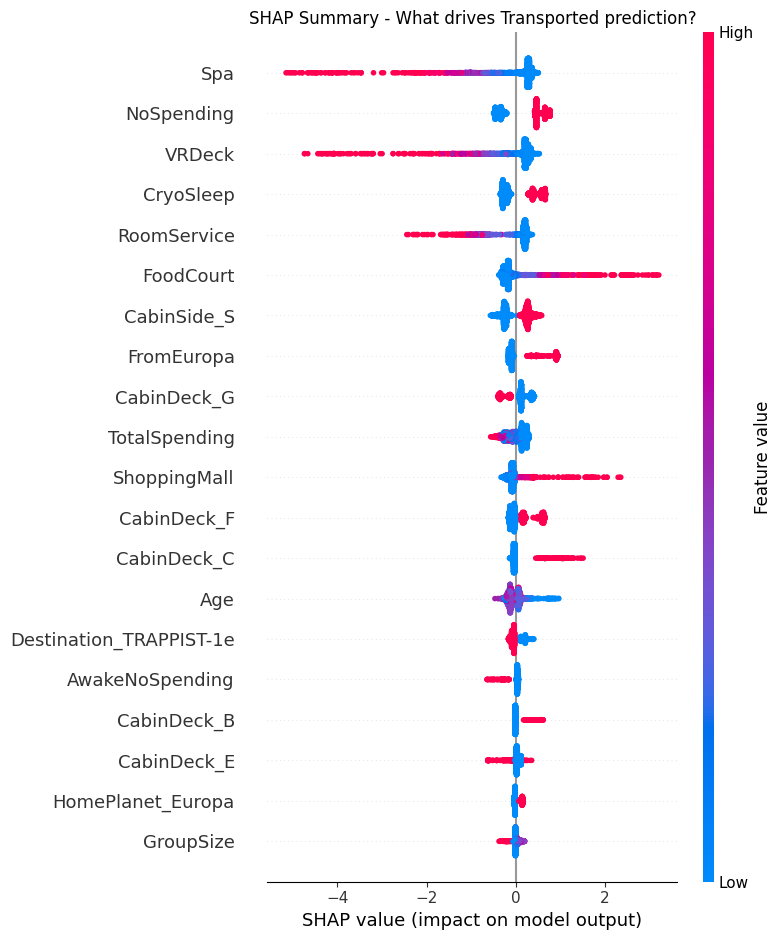

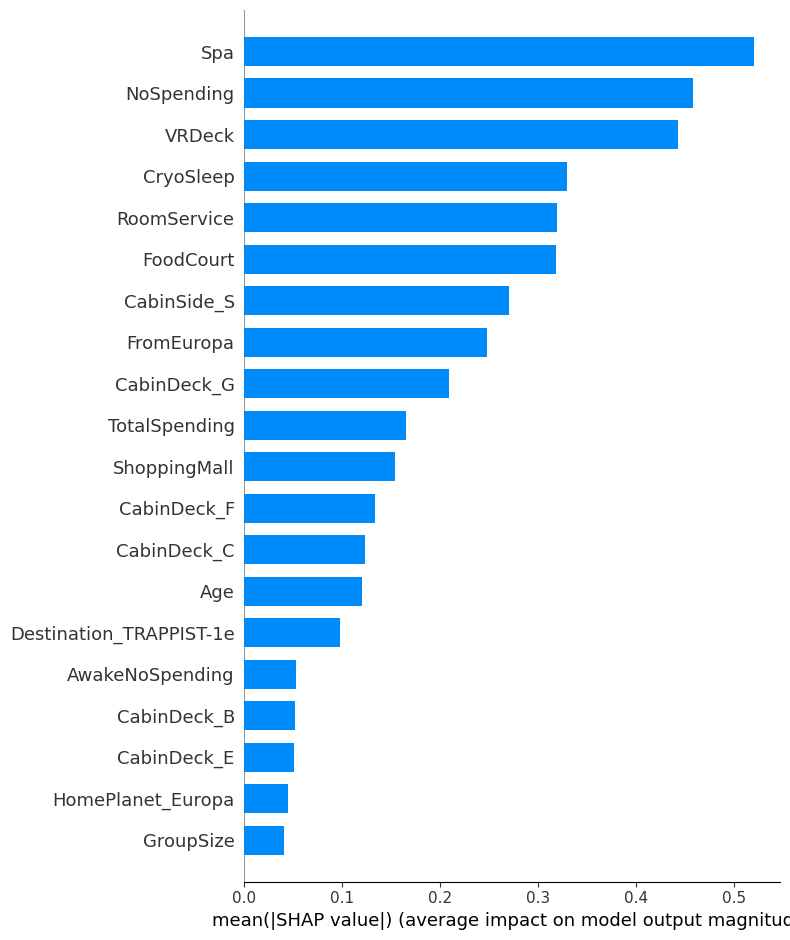

Top 10 features:
NoSpending           0.459401
CryoSleep            0.116650
CabinDeck_G          0.053128
FromEuropa           0.033947
HomePlanet_Europa    0.029980
TotalSpending        0.028107
CabinDeck_E          0.023831
Spa                  0.018946
CabinDeck_F          0.018882
FoodCourt            0.017555
dtype: float32


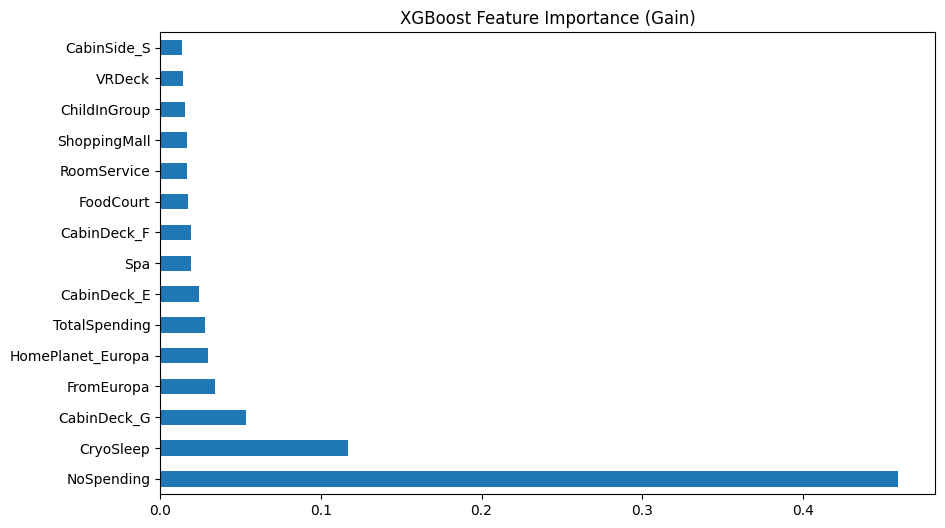

Overall error rate: 0.1926

Error when CryoSleep == 1: 0.1797
Error when CryoSleep == 0: 0.1995

Error when NoSpending == 1: 0.204
Error when FromEuropa == 1: 0.0774
Error when IsChild == 1: 0.2624
Error when AwakeNoSpending == 1: 0.3429
Error when ChildInGroup == 1: 0.2481
Error when AwakeNoSpending_CabinG == 1: 0.4098
Error when ChildCryo == 1: 0.2222
Best threshold: 0.44 → F1: 0.8207


In [99]:
df_encoded = preprocessing3(df)
best_model = get_best_model3(df_encoded)

In [103]:
# 1. AwakeNoSpending in Deck G (the 37.7% error group)

df = pd.read_csv("data/train.csv")
df_encoded = preprocessing3(df)
print(df_encoded.info())
X_train = df_encoded.copy()
X_train.drop(columns=["Transported"], inplace=True)
y_train= df_encoded['Transported'].astype(int)
# Retrain quickly
xgb = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
    
param_dist = {
    'n_estimators':     [100, 200, 300, 400],
    'max_depth':        [3, 5, 7, 9],
    'learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'subsample':        [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=15,           # only 15 random combinations – fast
    cv=5,                # 5-fold CV
    scoring='roc_auc',   # or 'f1' if you prefer
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_.round(4))

# Evaluate best model on validation set
best_model = search.best_estimator_
# Predict
df_test = pd.read_csv("data/test.csv")
df_test_encoded = preprocessing3(df_test)
test_proba = best_model.predict_proba(df_test_encoded)[:,1]
df_test['Transported'] = test_proba >= 0.44   # or use best threshold if you tuned one

# Submission format
submission = df_test[['PassengerId', 'Transported']]
submission.to_csv("submission_xgb_tuned.csv", index=False)
print("Submission file created!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   int32  
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   int32  
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Transported                8693 non-null   bool   
 9   GroupSize                  8693 non-null   int64  
 10  IsSolo                     8693 non-null   int32  
 11  TotalSpending              8693 non-null   float64
 12  NoSpending                 8693 non-null   int32  
 13  IsChild                    8693 non-null   int32

C:\Users\vinay\.conda\envs\torch311\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:29:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV ROC-AUC: 0.8906
Submission file created!
